In [1]:
# v5: change hadcrut to C&W

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
import seaborn as sns

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [2]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10

in_folder_tas = 'int_outputs/temperature_v2/'
# in_folder_tas = 'int_outputs/temperature_multi_ens/'

#exp='ssp370'
exp='ssp245'
#exp='ssp126'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

## observations
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available

tas_df = tas_df.groupby(['year', 'Experiment', 'Model']).mean().reset_index()

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()

global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])


for temp_thresh in [1.5,2]:

    Model = []
    No_arctic = []
    World = []
    df_proj = tas_df
    M_df = pd.DataFrame(columns=tas_df.columns)

    blues = []
    reds = []
    years = []

    for m in models:

        m_df = df_proj[df_proj['Model']==m].copy()
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
        m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()

        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=1)

        #also calc crossings again
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print()

observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278

observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278



In [3]:
m_df

,year,Experiment,Model,no_arctic_tas,world_tas,base_t_bnds,no_arctic_base_tas,world_base_tas,no_arctic_tas_anom,world_tas_anom,rolling_world_anom,rolling_no_arctic_anom,adjusted_world_tas_anom,adjusted_no_arctic_tas_anom
37,1850,historical,UKESM1-0-LL,287.831375,286.578596,1850-1900,287.698919,286.43595,0.132456,0.142646,NaN,NaN,NaN,NaN
75,1851,historical,UKESM1-0-LL,287.815172,286.578730,1850-1900,287.698919,286.43595,0.116253,0.142780,NaN,NaN,NaN,NaN
113,1852,historical,UKESM1-0-LL,287.794691,286.551025,1850-1900,287.698919,286.43595,0.095772,0.115075,NaN,NaN,NaN,NaN
151,1853,historical,UKESM1-0-LL,287.844838,286.610952,1850-1900,287.698919,286.43595,0.145919,0.175002,NaN,NaN,NaN,NaN
189,1854,historical,UKESM1-0-LL,287.750514,286.526811,1850-1900,287.698919,286.43595,0.051594,0.090861,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9728,2096,ssp245,UKESM1-0-LL,291.750977,290.828812,1850-1900,287.698919,286.43595,4.052058,4.392862,4.273106,3.929079,3.460766,3.109628
9770,2097,ssp245,UKESM1-0-LL,291.537208,290.627114,1850-1900,287.698919,286.43595,3.838289,4.191164,NaN,NaN,NaN,NaN
9812,2098,ssp245,UKESM1-0-LL,291.637047,290.711878,1850-1900,287.698919,286.43595,3.938127,4.275928,NaN,NaN,NaN,NaN
9854,2099,ssp245,UKESM1-0-LL,291.817259,290.897804,1850-1900,287.698919,286.43595,4.118340,4.461854,NaN,NaN,NaN,NaN


In [4]:
m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs

6413    1.234729
Name: rolling_world_anom, dtype: float64

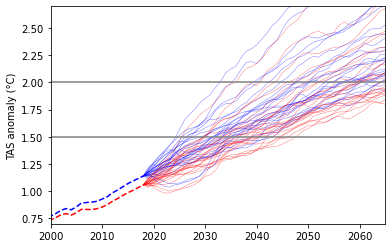

In [5]:
      
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')


for i in range(len(blues)):
    plt.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')

plt.savefig('Figures/tas_projections.png', dpi=300)

plt.show()


In [6]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

In [7]:
mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 2C: 7.75 +- 0.91 years


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2066.690,2056.820,9.870
1,CESM2,2043.424,2040.122,3.302
2,CESM2-WACCM,2051.975,2047.354,4.621
3,CIESM,2069.876,2056.276,13.600
4,EC-Earth3-Veg-LR,2067.646,2063.891,3.755
5,FIO-ESM-2-0,2070.413,2057.141,13.272
6,GFDL-CM4,2049.396,2044.639,4.757
7,GFDL-ESM4,2072.341,2059.456,12.885
8,GISS-E2-1-G,2040.582,2035.185,5.397
9,HadGEM3-GC31-LL,2047.419,2042.249,5.170


In [8]:
### now generate box plot by model (vertical), with multiple ensemble members for error bars

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()

#tas_df = tas_df[tas_df['Experiment'] != 'historical']
#tas_df = tas_df.drop(columns=['Experiment'])

#also calc crossings
Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']=='ssp245']['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e].copy()
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        except:
            print('error on: ' + m + e)
            
        me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
        me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

error on: E3SM-1-1r1i1p1f1


In [9]:
out_df_ME.dropna(inplace=True)

models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

7.3703902439024755


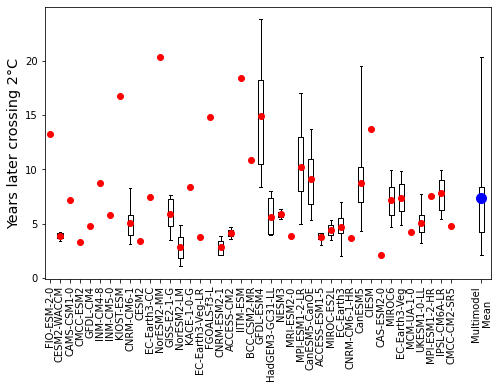

In [10]:
## plot

out_df_ME.dropna(inplace=True)

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]

means = np.array([list(v)[0] for v in vectors])


fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))

# for e, v in enumerate(vectors[:-1]):
#     ax.scatter(np.full(len(vers.loc[30].copy()
# ensemble_members.lo),e),v,color='k',s=8,zorder=10)
    
# ax.set_ylim(0,12)
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)

ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)

    
# print(np.nanmean(means))

ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')

# ax.xaxis.set_tick_params(rotation=90)
# # plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

# fig = plt.gcf()
# plt.tight_layout()
# plt.savefig('Figures/crossing_years_T.png', dpi=300)

plt.show()

Temp Thresh: 1.5
2036.9272307692308 2032.2851538461537 4.642076923077184
Temp Thresh: 2
2059.7901999999995 2052.03812 7.752079999999296


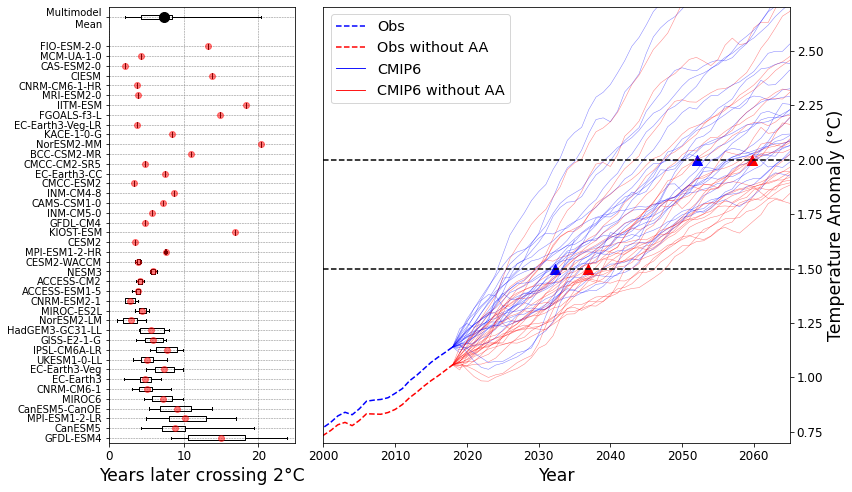

In [17]:
## combine both plots

models = ensemble_members['model']
out_df_ME.dropna(inplace=True)
vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

models_proj = df_proj['Model'].unique()

fig, (ax2, ax1) = plt.subplots(1,2,figsize=(12,7), gridspec_kw={'width_ratios': [1, 2.5]})
plt.rcParams['font.size'] = '12'

for i in range(len(blues)):
    ax1.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5)
    ax1.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5)


## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Obs')
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Obs without AA')

# legend_without_duplicate_labels(ax1,fontsize='large')

ax1.plot([],[],lw=0.9,label='CMIP6',color='b')
ax1.plot([],[],lw=0.9,label='CMIP6 without AA',color='r')

ax1.legend(fontsize='large')


ax1.set_xlim(2000,2065)
ax1.set_ylim(0.7, 2.7)
ax1.axhline(2, color='k',ls='--')
ax1.axhline(1.5, color='k',ls='--')
ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large')
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')


###########################################

ax2.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=False,
            meanprops={'marker':'o', 
                       #'markersize':10,
              'markerfacecolor':'r',
              'markeredgecolor':'r'})
mm_shift = 2
ax2.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticklabels(list(models)+['Multimodel\nMean'],rotation=0, fontsize='small')  

markersize=100
marker='^'
for temp_thresh in [1.5,2]:
    
    out_df = out_dfs[temp_thresh]
    
    x,y = np.nanmean(out_df['No_arctic_crossing_year']), np.nanmean(out_df['World_crossing_year'])
    
    ax1.scatter(x,temp_thresh,color='r',marker=marker,s=markersize)
    ax1.scatter(y,temp_thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {temp_thresh}')
    print(x,y,x-y)
    

# fig = plt.gcf()
plt.tight_layout()
plt.savefig('Figures/Combined.png', dpi=300)

plt.show()

In [12]:
np.nanmean(means)

7.3703902439024755

In [13]:
len(models)

41

In [14]:
out_dfs[1.5].shape

(26, 4)

In [15]:
l.se

NameError: name 'l' is not defined

In [ ]:
np.nanmean(blues)

In [ ]:
out_df